 Get History TLE data

In [1]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"

In [2]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



In [3]:
# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [4]:
# Dictyionary to store all starlink TLE data
starlink_tle_data = {}

# define time range
start_date = datetime(2021, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 5, 31, tzinfo=timezone.utc)

# search all TLE data in history
for filename in os.listdir(directory):
    if filename.startswith('satellite_TLE'):
        filepath = os.path.join(directory, filename)
        #print(filepath)

        # read file content
        with open(filepath, 'r') as file:
            lines = file.readlines()
            
            # extract starlink satellite TLE
            i = 0
            while i < len(lines):
                if lines[i].startswith('0 STARLINK'):
                    satellite_name = lines[i].strip().split(' ', 1)[1]  # remove the beginning number and space
                    tle1 = lines[i+1].strip()
                    tle2 = lines[i+2].strip()
                    if is_tle_in_date_range(tle1, start_date, end_date):
                        if satellite_name not in starlink_tle_data:
                            starlink_tle_data[satellite_name] = []
                        starlink_tle_data[satellite_name].append(f'{satellite_name}\n{tle1}\n{tle2}\n')
                    i += 3
                else:
                    i += 1

In [5]:
# save all starlink satellite into a new satellite file
with open(output_file, 'w') as output:
    for satellite_name, tles in starlink_tle_data.items():
        for tle in tles:
            output.write(tle)

print(f'All Starlink TLE data has been saved to {output_file}')

All Starlink TLE data has been saved to Starlink_TLE/TLE_history.txt


In [5]:
# Create output directory if it doesn't exist
output_directory = 'Starlink_TLE/Single_Satellite_TLE'
os.makedirs(output_directory, exist_ok=True)

# Save each satellite's TLE data to a separate file
for satellite_name, tles in starlink_tle_data.items():
    output_file_path = os.path.join(output_directory, f'{satellite_name}.txt')
    with open(output_file_path, 'w') as output_file:
        for tle in tles:
            output_file.write(tle)

print(f'All Starlink TLE data has been saved to {output_directory}')

All Starlink TLE data has been saved to Starlink_TLE/Single_Satellite_TLE


# Observe the satellites from specific location, time

In [6]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [10]:
# 定义时间和地点
ts = load.timescale()
columbus = Topos('39.9612 N', '82.9988 W')
target_time = ts.utc(2024, 2, 1, 0, 0, 0)  # 例如2024年5月1日12:00 UTC

In [11]:
# calculate every satellite's azimuth and degree
visible_satellites = []
for satellite_name, tles in starlink_tle_data.items():
    latest_tle = get_latest_tle(tles, target_time.utc_datetime())
    if latest_tle:
        #print(satellite_name)
        satellite = EarthSatellite(latest_tle.split('\n')[1], latest_tle.split('\n')[2], satellite_name, ts)
        difference = satellite - columbus
        topocentric = difference.at(target_time)
        alt, az, distance = topocentric.altaz()

        if alt.degrees > 0:  # 仅显示在地平线以上的卫星
            visible_satellites.append((satellite_name, az.degrees, alt.degrees, distance.km))

In [12]:
len(visible_satellites)

295

In [16]:
# 计算每颗卫星的海拔
altitudes = []
for satellite_name, tles in starlink_tle_data.items():
    latest_tle = get_latest_tle(tles, target_time.utc_datetime())
    if latest_tle:
        #print(satellite_name)
        satellite = EarthSatellite(latest_tle.split('\n')[1], latest_tle.split('\n')[2], satellite_name, ts)
        geocentric = satellite.at(target_time)
        subpoint = geocentric.subpoint()
        altitude = subpoint.elevation.km  # 获取海拔高度（km）
        altitudes.append(altitude)




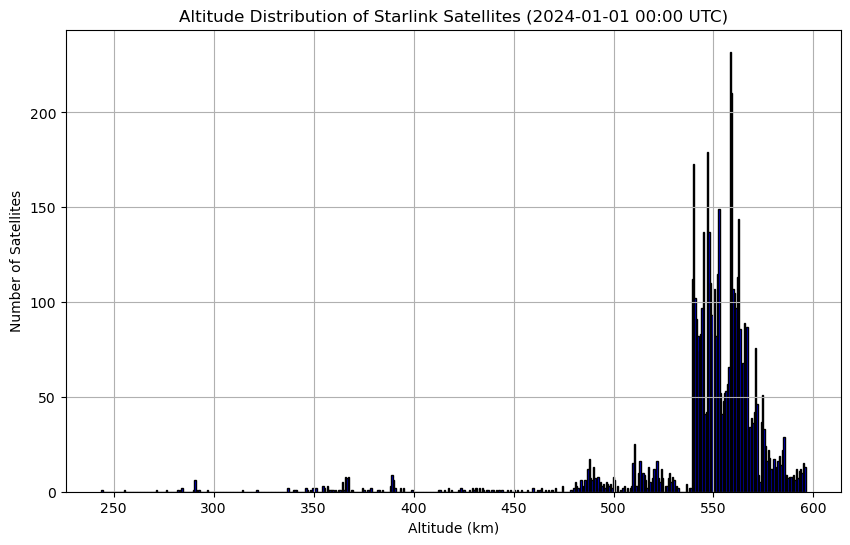

In [18]:
# 绘制海拔分布图
plt.figure(figsize=(10, 6))
plt.hist(altitudes, bins=500, color='blue', edgecolor='black')
plt.title('Altitude Distribution of Starlink Satellites (2024-01-01 00:00 UTC)')
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites')
plt.grid(True)
plt.show()

In [19]:
tles

['STARLINK-31824\n1 59804U 24093Y   24143.58334491 -.00888116  25058-3 -22071-2 0  9996\n2 59804  43.0039 353.0355 0001702 271.5798 169.1955 15.94919607  1851\n',
 'STARLINK-31824\n1 59804U 24093Y   24143.91667824 -.00889903  25000-3 -22831-2 0  9998\n2 59804  43.0036 350.9572 0001717 278.8996 277.8084 15.94327275  1901\n',
 'STARLINK-31824\n1 59804U 24093Y   24144.25001157 -.00949256  27967-3 -25091-2 0  9990\n2 59804  43.0038 348.8751 0002032 276.2307  35.6915 15.93777746  1956\n',
 'STARLINK-31824\n1 59804U 24093Y   24144.58334491 -.00894867  24963-3 -24425-2 0  9996\n2 59804  43.0034 346.7986 0001720 282.9541 143.4977 15.93163712  2023\n',
 'STARLINK-31824\n1 59804U 24093Y   24144.83335648 -.00916679  25970-3 -25609-2 0  9999\n2 59804  43.0032 345.2437 0001544 281.1562 140.7880 15.92726633  2067\n',
 'STARLINK-31824\n1 59804U 24093Y   24145.25001157 -.00950040  27527-3 -27551-2 0  9999\n2 59804  43.0032 342.6479 0001959 274.8889  18.4763 15.92017336  2115\n',
 'STARLINK-31824\n1 59

In [13]:
# 获取特定卫星在特定时间的正下方经纬度
satellite_name = 'STARLINK-1007'  # 例如，指定卫星名称
tles = starlink_tle_data.get(satellite_name)

if tles:
    latest_tle = get_latest_tle(tles, target_time.utc_datetime())
    print(latest_tle)
    if latest_tle:
        satellite = EarthSatellite(latest_tle.split('\n')[1], latest_tle.split('\n')[2], satellite_name, ts)
        geocentric = satellite.at(target_time)
        subpoint = geocentric.subpoint()
        latitude = subpoint.latitude.degrees
        longitude = subpoint.longitude.degrees

        print(f'Satellite: {satellite_name}')
        print(f'Latitude: {latitude:.6f} degrees')
        print(f'Longitude: {longitude:.6f} degrees')
    else:
        print(f'No TLE data available for {satellite_name} before the target time.')
else:
    print(f'No TLE data available for {satellite_name}.')

STARLINK-1007
1 44713U 19074A   24123.31941321  .00002843  00000-0  20960-3 0  9993
2 44713  53.0545 342.9614 0000908  88.5240 271.5853 15.06406425246978

Satellite: STARLINK-1007
Latitude: 2.722380 degrees
Longitude: 27.848933 degrees


# observe the dataset

In [15]:
# 定义计算时间点
ts = load.timescale()
calculation_time = ts.utc(2024, 1, 1, 0, 0, 0)

# 计算每颗卫星的海拔
altitudes = []
for satellite_name, tles in starlink_tle_data.items():
    latest_tle = get_latest_tle(tles, target_time.utc_datetime()) # 获取最新的TLE数据
    satellite = EarthSatellite(latest_tle[0], latest_tle[1], satellite_name, ts)
    difference = satellite - Topos('0 N', '0 E')
    topocentric = difference.at(calculation_time)
    alt, az, distance = topocentric.altaz()
    altitudes.append(distance.km)  # 将海拔高度（km）加入列表

# 绘制海拔分布图
plt.figure(figsize=(10, 6))
plt.hist(altitudes, bins=50, color='blue', edgecolor='black')
plt.title('Altitude Distribution of Starlink Satellites (2024-01-01 00:00 UTC)')
plt.xlabel('Altitude (km)')
plt.ylabel('Number of Satellites')
plt.grid(True)
plt.show()

NameError: name 'satellite_tle_data' is not defined

In [6]:
# 生成时间序列
start_time = datetime(2023, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 2, tzinfo=timezone.utc)
time_step = timedelta(minutes=3)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

# 初始化Skyfield时间尺度
ts = load.timescale()

# 找到start_time之后的第一个TLE数据
first_tle_index = next(i for i, (epoch, _, _) in enumerate(tle_data) if epoch >= start_time)
first_tle = tle_data[first_tle_index]

NameError: name 'tle_data' is not defined

In [ ]:
first_tle